# Load Data & Inspect

In [1]:
import pandas as pd
%matplotlib inline

In [2]:
deposits = pd.read_csv('tj_03_deposit_txn.csv')
accounts = pd.read_csv('tj_03_account_info.csv')

testdata = pd.read_csv('tj_03_test.csv', header=None)
traindata = pd.read_csv('tj_03_training.csv', header=None)

In [3]:
traindata.columns = ['account_no', 'label']
testdata.columns = ['account_no']

In [4]:
deposits['account_no'] = deposits['account_no'].astype(str)
accounts['account_no'] = deposits['account_no'].astype(str)

In [5]:
deposits.head()

,account_no,from_to_account_no,txn_amount,txn_dt,txn_hour,txn_type
0,3450019186,3450377309,50.0,2016-02-14 00:00:00,8,DR
1,3450034484,0,50.0,2016-02-14 00:00:00,16,DR
2,3450021883,0,5000.0,2016-02-14 00:00:00,9,DR
3,3450032248,3450321146,150.0,2016-02-14 00:00:00,19,DR
4,3450029267,3450070632,850.0,2016-02-14 00:00:00,21,DR


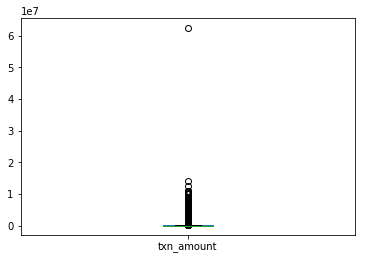

In [6]:
# TXN Amount Boxplot
deposits['txn_amount'].plot(kind='box')

In [7]:
deposits[deposits['txn_amount'] > 30000000]

,account_no,from_to_account_no,txn_amount,txn_dt,txn_hour,txn_type
392512,3450016391,3451107028,62500000.0,2016-03-28 00:00:00,11,DR


In [8]:
# Outlier is in train data
traindata[ traindata['account_no'] == 3450016391 ]

,account_no,label
5913,3450016391,0


In [9]:
# Drop outlier
traindata.drop(5913, inplace=True)

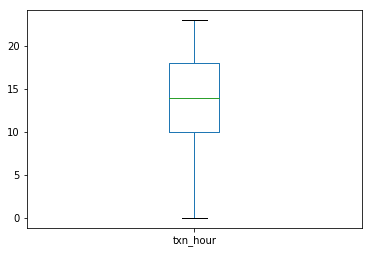

In [10]:
# TXN Hour Boxplot
deposits['txn_hour'].plot(kind='box')

In [11]:
deposits['txn_type'].value_counts()

DR    1900361
CR    1017941
Name: txn_type, dtype: int64

In [12]:
deposits.describe()

,from_to_account_no,txn_amount,txn_hour
count,2.918302e+06,2.918302e+06,2.918302e+06
mean,1.682077e+09,7.656600e+03,1.390190e+01
std,1.724751e+09,6.890537e+04,4.950484e+00
min,0.000000e+00,5.000000e+01,0.000000e+00
25%,0.000000e+00,2.000000e+02,1.000000e+01
50%,0.000000e+00,9.500000e+02,1.400000e+01
75%,3.450544e+09,4.350000e+03,1.800000e+01
max,3.451196e+09,6.250000e+07,2.300000e+01


In [13]:
deposits.describe(include=['O'])

,account_no,txn_dt,txn_type
count,2918302,2918302,2918302
unique,14020,261,2
top,3450004814,2016-09-30 00:00:00,DR
freq,19887,17595,1900361


In [14]:
# Add to outside feature
deposits['to_outside'] = (deposits['from_to_account_no'] > 0).astype('int')

In [15]:
pd.crosstab(deposits['to_outside'], deposits['txn_type'])

txn_type,CR,DR
to_outside,,
0,389580,1106119
1,628361,794242


## Create feature from 1st table

In [16]:
# Create deposit feature
dep_outside = deposits[['account_no', 'to_outside']].groupby('account_no').agg(['sum', 'count'])

acc_outside_df = pd.DataFrame({
    'outside_count': dep_outside['to_outside']['sum'],
    'all_count': dep_outside['to_outside']['count'],
    'outside_ratio': (dep_outside['to_outside']['sum']) / (dep_outside['to_outside']['count'])
})

acc_outside_df = acc_outside_df.reset_index()

In [17]:
acc_outside_df.head()

,account_no,all_count,outside_count,outside_ratio
0,3450000068,68,27,0.397059
1,3450000070,213,109,0.511737
2,3450000073,5,0,0.000000
3,3450000075,179,82,0.458101
4,3450000083,261,186,0.712644


In [18]:
deposits_dr = deposits[deposits['txn_type'] == 'DR']
deposits_cr = deposits[deposits['txn_type'] == 'CR']

In [19]:
# Create CR Features
dep_cr = deposits_cr[['account_no', 'txn_amount']].groupby('account_no').agg(['mean', 'count', 'sum'])

acc_cr = pd.DataFrame({
    'cr_mean': dep_cr['txn_amount']['mean'],
    'cr_count': dep_cr['txn_amount']['count'],
    'cr_sum': dep_cr['txn_amount']['sum']
})

acc_cr = acc_cr.reset_index()

acc_cr.head()

,account_no,cr_count,cr_mean,cr_sum
0,3450000068,24,833.333333,20000.0
1,3450000070,122,2186.475410,266750.0
2,3450000075,79,11115.189873,878100.0
3,3450000083,98,16017.857143,1569750.0
4,3450000087,21,69795.238095,1465700.0


In [20]:
# Create DR Features
dep_dr = deposits_dr[['account_no', 'txn_amount']].groupby('account_no').agg(['mean', 'count', 'sum'])

acc_dr = pd.DataFrame({
    'dr_mean': dep_dr['txn_amount']['mean'],
    'dr_count': dep_dr['txn_amount']['count'],
    'dr_sum': dep_dr['txn_amount']['sum']
})

acc_dr = acc_dr.reset_index()

acc_dr.head()

,account_no,dr_count,dr_mean,dr_sum
0,3450000068,44,518.181818,22800.0
1,3450000070,91,3662.087912,333250.0
2,3450000073,5,50.000000,250.0
3,3450000075,100,7271.500000,727150.0
4,3450000083,163,4845.398773,789800.0


In [21]:
# Create Outside DR Feature
dep_outside_dr = deposits[ (deposits['to_outside'] == 1) & (deposits['txn_type'] == 'DR') ]
dep_outside_dr = dep_outside_dr[['account_no', 'txn_amount']].groupby('account_no').agg(['count', 'sum'])

acc_dr_outside = pd.DataFrame({
    'dr_outside_sum': dep_outside_dr['txn_amount']['sum'],
    'dr_outside_count': dep_outside_dr['txn_amount']['count']
})

acc_dr_outside = acc_dr_outside.reset_index()

In [22]:
# Create Outside DR Feature
dep_outside_cr = deposits[ (deposits['to_outside'] == 1) & (deposits['txn_type'] == 'CR') ]
dep_outside_cr = dep_outside_cr[['account_no', 'txn_amount']].groupby('account_no').agg(['count', 'sum'])

acc_cr_outside = pd.DataFrame({
    'cr_outside_sum': dep_outside_cr['txn_amount']['sum'],
    'cr_outside_count': dep_outside_cr['txn_amount']['count']
})

acc_cr_outside = acc_cr_outside.reset_index()

In [23]:
# Merge all deposits features
acc_deposits = acc_outside_df.merge(acc_cr, how='outer', on='account_no')
acc_deposits = acc_deposits.merge(acc_dr, how='outer', on='account_no')
acc_deposits = acc_deposits.merge(acc_dr_outside, how='outer', on='account_no')
acc_deposits = acc_deposits.merge(acc_cr_outside, how='outer', on='account_no')
acc_deposits = acc_deposits.fillna(0)
acc_deposits.head()

,account_no,all_count,outside_count,outside_ratio,cr_count,cr_mean,cr_sum,dr_count,dr_mean,dr_sum,dr_outside_count,dr_outside_sum,cr_outside_count,cr_outside_sum
0,3450000068,68,27,0.397059,24.0,833.333333,20000.0,44.0,518.181818,22800.0,9.0,3450.0,18.0,14650.0
1,3450000070,213,109,0.511737,122.0,2186.475410,266750.0,91.0,3662.087912,333250.0,46.0,111050.0,63.0,130000.0
2,3450000073,5,0,0.000000,0.0,0.000000,0.0,5.0,50.000000,250.0,0.0,0.0,0.0,0.0
3,3450000075,179,82,0.458101,79.0,11115.189873,878100.0,100.0,7271.500000,727150.0,37.0,437150.0,45.0,411450.0
4,3450000083,261,186,0.712644,98.0,16017.857143,1569750.0,163.0,4845.398773,789800.0,96.0,649500.0,90.0,1397100.0


In [24]:
# -- Make account features
accounts.head(10)

,account_no,txn_dt,open_date,customer_type,last_active_date,dormant_days,compound_frq,compound_frq_unit,eff_interest_rate
0,3450019186,2016-10-31 00:00:00,2014-02-07 00:00:00,704,2016-10-31 00:00:00,0,6,M,0.5
1,3450034484,2016-08-30 00:00:00,2011-01-17 00:00:00,704,2016-08-29 00:00:00,1,6,M,0.5
2,3450021883,2016-10-02 00:00:00,2003-06-03 00:00:00,704,2016-10-01 00:00:00,1,6,M,0.5
3,3450032248,2016-10-27 00:00:00,2014-03-17 00:00:00,704,2016-10-24 00:00:00,3,6,M,0.5
4,3450029267,2016-08-08 00:00:00,2015-05-31 00:00:00,704,2016-08-07 00:00:00,1,6,M,0.5
5,3450049023,2016-08-03 00:00:00,2014-04-22 00:00:00,704,2016-08-03 00:00:00,0,6,M,0.5
6,3450044551,2016-10-07 00:00:00,2015-02-18 00:00:00,704,2016-10-07 00:00:00,0,6,M,0.5
7,3450036531,2016-08-25 00:00:00,2016-02-01 00:00:00,704,2016-08-25 00:00:00,0,6,M,0.5
8,3450016625,2016-09-10 00:00:00,2015-02-14 00:00:00,704,2016-09-08 00:00:00,2,6,M,0.5
9,3450037575,2016-10-03 00:00:00,2012-02-24 00:00:00,704,2016-10-03 00:00:00,0,6,M,0.5


In [25]:
# Label Encode ? One account has multiple customer types :/
accounts['customer_type'].value_counts()

704     474574
702      28668
1003     17194
707       6771
703       2495
804          6
803          1
Name: customer_type, dtype: int64

In [26]:
accounts[ accounts['account_no'] == '3450036531' ]

,account_no,txn_dt,open_date,customer_type,last_active_date,dormant_days,compound_frq,compound_frq_unit,eff_interest_rate
7,3450036531,2016-08-25 00:00:00,2016-02-01 00:00:00,704,2016-08-25 00:00:00,0,6,M,0.5
67,3450036531,2016-10-09 00:00:00,2009-03-06 00:00:00,704,2016-10-09 00:00:00,0,6,M,0.5
485,3450036531,2016-10-16 00:00:00,2002-05-29 00:00:00,704,2016-10-13 00:00:00,3,6,M,0.5
1468,3450036531,2016-09-25 00:00:00,2009-05-14 00:00:00,704,2016-09-21 00:00:00,4,6,M,0.5
2059,3450036531,2016-09-28 00:00:00,2007-06-02 00:00:00,704,2016-09-22 00:00:00,6,6,M,0.5
3000,3450036531,2016-09-05 00:00:00,2016-06-22 00:00:00,704,2016-08-31 00:00:00,5,6,M,0.5
3067,3450036531,2016-10-25 00:00:00,2010-06-11 00:00:00,704,2016-10-25 00:00:00,0,6,M,0.5
3244,3450036531,2016-08-16 00:00:00,2011-03-14 00:00:00,704,2016-08-10 00:00:00,6,6,M,0.5
3389,3450036531,2016-09-15 00:00:00,2015-06-06 00:00:00,704,2016-09-15 00:00:00,0,6,M,0.5
3894,3450036531,2016-10-20 00:00:00,2015-05-05 00:00:00,704,2016-10-20 00:00:00,0,6,M,0.5


In [27]:
accounts.describe()

,customer_type,dormant_days,compound_frq,eff_interest_rate
count,529709.000000,529709.000000,529709.0,529709.0
mean,713.632056,3.107272,6.0,0.5
std,53.005599,34.117037,0.0,0.0
min,702.000000,-1.000000,6.0,0.5
25%,704.000000,0.000000,6.0,0.5
50%,704.000000,0.000000,6.0,0.5
75%,704.000000,1.000000,6.0,0.5
max,1003.000000,1589.000000,6.0,0.5


In [28]:
accounts.describe(include=['O'])

,account_no,txn_dt,open_date,last_active_date,compound_frq_unit
count,529709,529709,529709,529709,529709
unique,10901,92,2838,670,1
top,3450047827,2016-10-31 00:00:00,2016-02-08 00:00:00,2016-09-30 00:00:00,M
freq,2340,14020,1429,7050,529709


## Create feature from 2nd table

In [29]:
# Create account feature
acc_meandorm = accounts[['account_no', 'dormant_days']].groupby('account_no').agg(['mean', 'sum'])

acc_meandorm_df = pd.DataFrame({
    'dorm_mean': acc_meandorm['dormant_days']['mean'],
    'dorm_sum': acc_meandorm['dormant_days']['sum']
})

acc_meandorm_df = acc_meandorm_df.reset_index()

## Combine all features

In [30]:
acc_fulldata = acc_deposits.merge(acc_meandorm_df, how='outer', on='account_no')
acc_fulldata = acc_fulldata.fillna(0)
acc_fulldata.head()

,account_no,all_count,outside_count,outside_ratio,cr_count,cr_mean,cr_sum,dr_count,dr_mean,dr_sum,dr_outside_count,dr_outside_sum,cr_outside_count,cr_outside_sum,dorm_mean,dorm_sum
0,3450000068,68,27,0.397059,24.0,833.333333,20000.0,44.0,518.181818,22800.0,9.0,3450.0,18.0,14650.0,1.235294,21.0
1,3450000070,213,109,0.511737,122.0,2186.475410,266750.0,91.0,3662.087912,333250.0,46.0,111050.0,63.0,130000.0,1.490196,76.0
2,3450000073,5,0,0.000000,0.0,0.000000,0.0,5.0,50.000000,250.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,3450000075,179,82,0.458101,79.0,11115.189873,878100.0,100.0,7271.500000,727150.0,37.0,437150.0,45.0,411450.0,0.921053,35.0
4,3450000083,261,186,0.712644,98.0,16017.857143,1569750.0,163.0,4845.398773,789800.0,96.0,649500.0,90.0,1397100.0,0.900000,54.0


## Combine test & train data

In [31]:
acc_fulldata[ acc_fulldata['account_no'] == '3450003077']

,account_no,all_count,outside_count,outside_ratio,cr_count,cr_mean,cr_sum,dr_count,dr_mean,dr_sum,dr_outside_count,dr_outside_sum,cr_outside_count,cr_outside_sum,dorm_mean,dorm_sum
890,3450003077,155,117,0.754839,50.0,27676.0,1383800.0,105.0,10354.285714,1087200.0,76.0,1009950.0,41.0,604100.0,0.461538,6.0


In [32]:
acc_fulldata['account_no'] = acc_fulldata['account_no'].astype(int)

In [44]:
# Log Transform
import numpy as np
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p)

acc_fulldata['cr_mean_lg'] = transformer.transform(acc_fulldata['cr_mean'].values.reshape(-1, 1))
acc_fulldata['cr_sum_lg'] = transformer.transform(acc_fulldata['cr_sum'].values.reshape(-1, 1))
acc_fulldata['dr_mean_lg'] = transformer.transform(acc_fulldata['dr_mean'].values.reshape(-1, 1))
acc_fulldata['dr_sum_lg'] = transformer.transform(acc_fulldata['dr_sum'].values.reshape(-1, 1))
acc_fulldata['cr_outside_sum_lg'] = transformer.transform(acc_fulldata['cr_outside_sum'].values.reshape(-1, 1))
acc_fulldata['dr_outside_sum_lg'] = transformer.transform(acc_fulldata['dr_outside_sum'].values.reshape(-1, 1))
acc_fulldata['dorm_mean_lg'] = transformer.transform(acc_fulldata['dorm_mean'].values.reshape(-1, 1))
acc_fulldata['dorm_sum_lg'] = transformer.transform(acc_fulldata['dorm_sum'].values.reshape(-1, 1))

In [45]:
traindata_full = traindata.merge(acc_fulldata, how='left', on='account_no')
testdata_full = testdata.merge(acc_fulldata, how='left', on='account_no')

In [46]:
traindata_full.head()

,account_no,label,all_count,outside_count,outside_ratio,cr_count,cr_mean,cr_sum,dr_count,dr_mean,...,dorm_mean,dorm_sum,cr_mean_lg,cr_sum_lg,dr_mean_lg,dr_sum_lg,cr_outside_sum_lg,dr_outside_sum_lg,dorm_sum_lg,dorm_mean_lg
0,3450003077,0,155,117,0.754839,50.0,27676.000000,1383800.0,105.0,10354.285714,...,0.461538,6.0,10.228357,14.140345,9.245252,13.899117,13.311497,13.825412,1.945910,0.379490
1,3450049063,0,109,33,0.302752,31.0,5743.548387,178050.0,78.0,1868.589744,...,1.000000,1.0,8.656007,12.089825,7.533474,11.889655,9.433564,10.719980,0.693147,0.693147
2,3450042690,0,241,123,0.510373,88.0,2616.477273,230250.0,153.0,1676.143791,...,0.750000,12.0,7.869966,12.346925,7.424848,12.454693,12.064803,12.115333,2.564949,0.559616
3,3450002750,1,3,1,0.333333,0.0,0.000000,0.0,3.0,28333.333333,...,0.000000,0.0,0.000000,0.000000,10.251830,11.350418,0.000000,10.126671,0.000000,0.000000
4,3450028012,0,347,244,0.703170,60.0,7464.166667,447850.0,287.0,1648.257840,...,1.095238,69.0,8.918003,13.012216,7.408081,13.066958,12.611208,12.529065,4.248495,0.739667


In [47]:
testdata_full.head()

,account_no,all_count,outside_count,outside_ratio,cr_count,cr_mean,cr_sum,dr_count,dr_mean,dr_sum,...,dorm_mean,dorm_sum,cr_mean_lg,cr_sum_lg,dr_mean_lg,dr_sum_lg,cr_outside_sum_lg,dr_outside_sum_lg,dorm_sum_lg,dorm_mean_lg
0,3450025664,1,0,0.000000,0.0,0.000000,0.0,1.0,50.000000,50.0,...,0.000000,0.0,0.000000,0.000000,3.931826,3.931826,0.000000,0.000000,0.000000,0.000000
1,3450004335,173,166,0.959538,58.0,5532.758621,320900.0,115.0,2248.695652,258600.0,...,0.000000,0.0,8.618623,12.678888,7.718550,12.463042,12.678888,12.461300,0.000000,0.000000
2,3450005218,99,32,0.323232,16.0,35775.000000,572400.0,83.0,2174.096386,180450.0,...,0.000000,0.0,10.485033,13.257595,7.684828,12.103215,9.695910,11.101206,0.000000,0.000000
3,3450038376,319,180,0.564263,99.0,7162.121212,709050.0,220.0,3317.045455,729750.0,...,1.229730,91.0,8.876701,13.471683,8.107131,13.500459,12.912509,13.097663,4.521789,0.801880
4,3450044475,20,2,0.100000,9.0,499000.000000,4491000.0,11.0,141395.454545,1555350.0,...,0.333333,1.0,13.120363,15.317586,11.859323,14.257212,15.201805,11.918397,0.693147,0.287682


## Predict

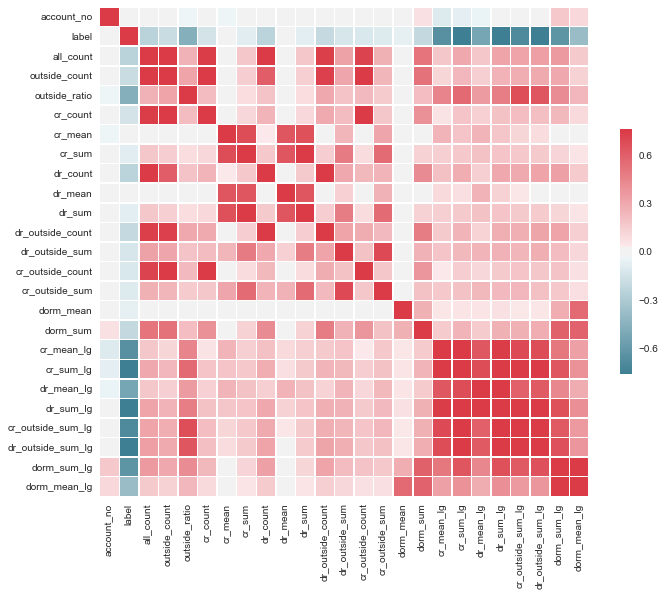

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = traindata_full.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [49]:
# Predict
from sklearn.model_selection import cross_val_score, train_test_split

In [150]:
# Settings
use_columns = [
    'outside_ratio',
    'cr_mean_lg',
    'cr_sum_lg',
    'dr_mean_lg',
    'dr_sum_lg',
    'dr_outside_sum_lg',
    'dr_outside_count',
    'cr_outside_sum_lg',
    'cr_outside_count',
    'dorm_mean_lg',
    'dorm_sum_lg'
]

target_column = 'label'

# from sklearn.naive_bayes import GaussianNB
# model = GaussianNB()

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=100)

# from sklearn.ensemble import AdaBoostClassifier
# model = AdaBoostClassifier(n_estimators=50, learning_rate=0.1)

from sklearn import svm
model = svm.SVC(C=10, gamma=0.01)

# model = XGBClassifier(max_depth=5)

testsze = 0.3

In [151]:
# Test Model
x_train, x_test, y_train, y_test = train_test_split(
    traindata_full[use_columns],
    traindata_full[target_column], test_size = testsze)

estimator = model.fit(x_train, y_train)

np.mean(cross_val_score(estimator, x_test, y_test, cv=10))

0.94264676157366201

In [147]:
# # Find Parameters

# from sklearn.model_selection import GridSearchCV
# # parameters = {'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.5,0.7,1], 'n_estimators':[10,30,50,70,100,200,500,1000]}
# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]
# param_grid = {'C': Cs, 'gamma' : gammas}
# model = svm.SVC()
# clf = GridSearchCV(model, param_grid)
# clf.fit(x_train, y_train)
# print(clf.best_params_)
# print(clf.cv_results_)

In [148]:
# Find features important

# from sklearn.feature_selection import SelectFromModel
# model = SelectFromModel(estimator, prefit=True)

# estimator.feature_importances_

In [152]:
# Save File
predict_y = estimator.predict(testdata_full[use_columns])

np.savetxt('3.txt', predict_y, fmt="%d")